In [20]:
import numpy as numpy
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets,transforms
from torch import nn, optim

In [21]:
transform = transforms.ToTensor() #converter imagem para tensor
trainset = datasets.MNIST('./MNIST_data/' , download=True,train=True,transform=transform) #parte de treino do dataset
trainloader = torch.utils.data.DataLoader(trainset,batch_size=64,shuffle=True) #buffer para pegar os dados por partes

valset = datasets.MNIST('./MNIST_data/' , download=True,train=False,transform=transform) #parte de validacao do dataset
valloader = torch.utils.data.DataLoader(valset,batch_size=64,shuffle=True) #buffer para pegar os dados por partes

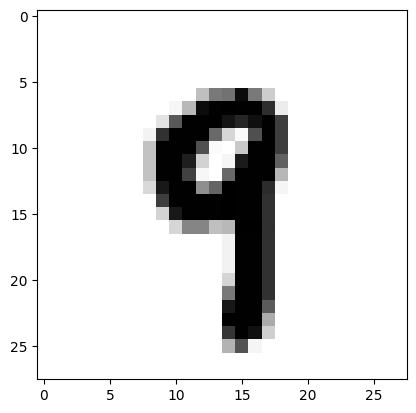

In [22]:
dataiter = iter(trainloader)
imagens, etiquetas = next(dataiter)
plt.imshow(imagens[0].numpy().squeeze(),cmap ='gray_r' )

In [23]:
print(imagens[0].shape) #verificar as dimensoes do shape do tensor de cada imagem
print(etiquetas[0].shape) #verificar as dimensoes do shape do tensor de cada etiqueta

torch.Size([1, 28, 28])
torch.Size([])


In [24]:
class Model(nn.Module):
  def __init__(self):
    super(Model,self).__init__()
    self.linear1 = nn.Linear(28*28,128) #camada de entrada 784 neuronios que se ligam a 128
    self.linear2 = nn.Linear(128,64) #camada interna 1, 128 neuronios que se ligam a 64
    self.linear3 = nn.Linear(64,10) #camada interna 2, 64 neuronios que se ligam a 10
    #para a camada de saida n precisa definir nada , so pegar o output da camada interna 2

  def forward(self,X):
    X = F.relu(self.linear1(X)) #funcao de ativacao da camada de entrada para a camada interna 1
    X = F.relu(self.linear2(X)) #funcao de ativacao da camada interna 1 para a camada interna 2
    X = self.linear3(X) #função de ativação da camada  interna 2 para a camada de saida, nesser caso f(x) = x
    return F.log_softmax(X,dim=1)#dados utilzados para calcular a perda

In [25]:
def treino(model,trainloader,device):

  otimizador = optim.SGD(model.parameters(),lr=0.01,momentum=0.5) #define politica de atualização dos pesos e bias
  inicio = time() #timer
  criterio = nn.NILLLoss() #definindo criterio para calcular a perda
  EPOCHS = 10 # numero de epocas
  model.train()#ativando modo de treinamento

  for epoch in range(EPOCHS):
    perda_acumulada = 0.0 #acumulador de perda

    for imagens,etiquetas in trainloader :
      imagens = imagens.view(imagens.shape[0], -1) # convertendo imagens para vetores e 28*28 casas para
      otimizador.zero_grad()#zerando os gradientes

      output = model(imagens.to(device))#colocando dados no modelo
      perda_instantanea = criterio(output,etiquetas.to(device)) #calculando a perda da epoch em questao

      perda_instantanea.backward() #back propagation a partir da perda

      otimizador.step()# atualizando os pesos e bias

      perda_acumulada += perda_instantanea.item()

    else:
      print("Epoch {} - Perda Resultante: {}".format(epoch+1,perda_acumulada/len(trainloader)))

  print("\nTempo de treino (em minutos)=",(time()-inicio)/60)

In [26]:
def vallidacao(model,valloader,device):
  conta_corretas,conta_todas = 0,0
  for imagens,etiquetas in valloader:
    for i in range(len(etiquetas)):
      img = imagens[i].view(1,784)

      with torch.no_grad():
          logps = model(img.to(device))

      ps = torch.exp(logps)
      probab = list(ps.cpu().numpy()[0])
      etiqueta_pred = probab.index(max(probab))
      etiqueta_certa = etiquetas.numpy()[i]
      if(etiqueta_certa == etiqueta_pred):
        conta_corretas += 1
      conta_todas += 1

  print("Total de imagens testadas =",conta_todas)
  print("\nPrecisão do modelo = {}%".format(conta_corretas*100/conta_todas))

In [27]:
model = Model()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Model(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)